In [105]:
import kagglehub
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm
import torch.nn as nn
from collections import defaultdict
from transformers import CLIPVisionModel, CLIPImageProcessor
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')
print(device)

cuda


In [25]:
path = kagglehub.dataset_download("ponaekj/artifact-mini")
root_path = os.path.join(path, 'root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/')
root_path = '/root/.cache/kagglehub/datasets/ponaekj/artifact-mini/versions/5/root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/'
print(root_path)

/root/.cache/kagglehub/datasets/ponaekj/artifact-mini/versions/5/root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/


In [20]:
drive.mount('/content/drive')
root_path= "/content/drive/MyDrive/artifact"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
real_sources = [
    "ffhq",          # Flickr-Faces-HQ
    "imagenet",      # ImageNet
    "lsun",          # LSUN Scene Understanding
    "landscape",     # Пейзажи (например, Landscape Photos)
    "metfaces",      # MetFaces
    "afhq",          # Animal Faces-HQ
    "celebahq",      # CelebA-HQ
    "coco"           # Common Objects in Context
]

In [22]:
fake_methods = [
    # 13 GANs
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "pro_gan",
    "projected_gan", "gau_gan", "star_gan", "gansformer", "generative_inpainting",
    "mat", "palette", "taming_transformer",

    # 7 Diffusion
    "ddpm", "latent_diffusion", "stable_diffusion", "vq_diffusion",
    "glide", "lama", "denoising_diffusion_gan",

    # 5 Others
    "face_synthetics", "cips", "cycle_gan", "sfhq", "diffusion_gan"
]

In [14]:
def split_dataset(root_dir, test_size=0.2, random_state=42):
    """
    Разделяет данные на train/test с сохранением структуры папок
    """
    # Создаем директории для train и test
    train_dir = os.path.join(root_dir, 'train')
    test_dir = os.path.join(root_dir, 'test')
    if os.path.exists(train_dir) or os.path.exists(test_dir):
        print("⚠️ Папки train/test уже существуют. Удалите их вручную для повторного разделения.")
        return
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Собираем все файлы с сохранением структуры

    for folder in os.listdir(root_dir):
        if folder in ['train', 'test']:  # Пропускаем уже созданные
            continue

        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Создаем аналогичные папки в train и test
        os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

        # Получаем все файлы и разделяем
        all_files = []
        for root, _, files in os.walk(folder_path):
            if 'train' in root.split(os.sep) or 'test' in root.split(os.sep):
                continue
            for file in files:
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_files.append(os.path.join(root, file))

        # Стратифицированное разделение
        if all_files:
            # Создаем метки для стратификации
            labels = [0 if folder in real_sources else 1 for _ in all_files]
            train_files, test_files = train_test_split(
                all_files,
                test_size=test_size,
                random_state=random_state,
                stratify=labels
            )

            # Копируем файлы
            for file in train_files:
                shutil.copy(file, os.path.join(train_dir, folder, os.path.basename(file)))
            for file in test_files:
                shutil.copy(file, os.path.join(test_dir, folder, os.path.basename(file)))

    print(f"Данные разделены: {len(os.listdir(train_dir))} классов в train, {len(os.listdir(test_dir))} в test")

# Использование
split_dataset(root_path, test_size=0.2)

Данные разделены: 33 классов в train, 33 в test


In [15]:
class ArtiFactDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.real_sources = real_sources  # 8 источников
        self.fake_methods = fake_methods  # 25 методов

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)

            if folder in self.real_sources:
                label_method = "real"
                is_fake = 0  # 0 для реальных изображений
            elif folder in self.fake_methods:
                label_method = folder  # Название метода генерации
                is_fake = 1  # 1 для сгенерированных изображений
            else:
                print(f"⚠️ Неизвестная папка: '{folder}'. Пропускаем...")
                continue

            # Рекурсивно собираем все изображения
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.lower().endswith((".jpg", ".png", ".jpeg")):
                        self.samples.append((
                            os.path.join(root, file),
                            label_method,  # Метка метода ("real", "stylegan3" и т.д.)
                            is_fake       # Бинарный флаг (0 или 1)
                        ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_method, is_fake = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label_method, is_fake  # Возвращаем изображение, текстовую метку и бинарный флаг


# Пример использования
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_train = ArtiFactDataset(root_dir=os.path.join(root_path, "train"), transform=transform)
print(dataset_train.__len__())
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataset_test = ArtiFactDataset(root_dir=os.path.join(root_path, "test"), transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

# Проверка
for images, labels, flag in dataloader_train:
    print(f"Batch shape: {images.shape}, Labels: {labels}, ItsFake: {flag}")
    break

9108
Batch shape: torch.Size([32, 3, 224, 224]), Labels: ('real', 'glide', 'stable_diffusion', 'lama', 'real', 'real', 'stylegan2', 'gau_gan', 'real', 'taming_transformer', 'pro_gan', 'gansformer', 'vq_diffusion', 'diffusion_gan', 'palette', 'real', 'real', 'real', 'generative_inpainting', 'cycle_gan', 'real', 'stable_diffusion', 'palette', 'lama', 'real', 'lama', 'real', 'cips', 'real', 'projected_gan', 'real', 'gansformer'), ItsFake: tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1])


In [27]:
ALL_METHODS = ['real'] + fake_methods

class ArtiFactDataset(Dataset):
    def __init__(self, root_dir, all_methods, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.all_methods = all_methods  # Сохраняем внешний список
        self.samples = []  # (путь_к_файлу, индекс_метода, is_fake)

        # Сканируем папки и связываем с индексами
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)

            # Определяем метод и флаг
            if folder in real_sources:
                method_idx = 0  # real всегда имеет индекс 0
                is_fake = 0
            else:
                try:
                    method_idx = all_methods.index(folder)
                    is_fake = 1
                except ValueError:
                    print(f"⚠️ Неизвестный метод: '{folder}'. Пропускаем...")
                    continue

            # Собираем файлы
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.samples.append((
                            os.path.join(root, file),
                            method_idx,
                            is_fake
                        ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, method_idx, is_fake = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, method_idx, is_fake

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_train = ArtiFactDataset(root_dir=os.path.join(root_path, "train"), all_methods=ALL_METHODS, transform=transform)
print(dataset_train.__len__())
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataset_test = ArtiFactDataset(root_dir=os.path.join(root_path, "test"), all_methods=ALL_METHODS, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

ALL_METHODS = np.array(ALL_METHODS)
for images, labels, flag in dataloader_train:
    print(f"Batch shape: {images.shape}, Labels: {labels}, ItsFake: {flag}")
    print(np.array(ALL_METHODS)[labels.numpy()])
    break

9108
Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([ 3,  1, 19,  0, 17, 20,  0,  0, 19,  0,  6,  0,  0,  2, 10,  0,  0,  0,
         0,  3,  0, 13,  8, 25,  0,  9,  4, 22,  5,  2,  0, 13]), ItsFake: tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1])
['stylegan3' 'stylegan1' 'lama' 'real' 'vq_diffusion'
 'denoising_diffusion_gan' 'real' 'real' 'lama' 'real' 'projected_gan'
 'real' 'real' 'stylegan2' 'generative_inpainting' 'real' 'real' 'real'
 'real' 'stylegan3' 'real' 'taming_transformer' 'star_gan' 'diffusion_gan'
 'real' 'gansformer' 'big_gan' 'cips' 'pro_gan' 'stylegan2' 'real'
 'taming_transformer']


In [96]:
def plot_histories(histories, names):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict) accuracy и loss на обучении и валидации
    :param names: (dict) название модели
    '''
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown']
    fig, axs = plt.subplots(1, 3, figsize=(14, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        axs[1].legend()

        axs[2].set_title('Время на проход')
        axs[2].plot(history['time_backward'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[2].plot(history['time_forward'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[2].set_xlabel('Эпохи')
        axs[2].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)

    legend = axs[2].legend(loc=3-2)
    axs[2].legend(dummy_lines, ["forward", "backward"], loc=4)
    axs[2].add_artist(legend)
    plt.show()


def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=5,
    binary = True
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))
    averag_time_back = np.zeros(num_epochs)
    averag_time_front = np.zeros(num_epochs)

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0


        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, label_batch,  y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            label_batch = label_batch.to(device)
            y_batch_bin = y_batch.to(device)
            if not binary:
              y_batch = label_batch
            # Логиты на выходе модели
            start_time = time.time()
            logits = model(X_batch)
            start_time = time.time() - start_time
            averag_time_front[epoch] += start_time


            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            start_time = time.time()
            loss.backward()
            start_time = time.time() - start_time
            averag_time_back[epoch] += start_time
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

            # Сохраняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            y_pred = (y_pred != 0)
            train_acc += np.mean(y_batch_bin.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации
        for X_batch, _, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты, полученные моделью
            logits = model(X_batch)
            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            print(y_pred)
            y_pred = (y_pred != 0) # на случай многоклассовой класификации
            print(y_pred)
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output(wait=True)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  backward time: {} c.".format(averag_time_front[epoch]))
        print("  forward time: {} c.".format(averag_time_back[epoch]))

    history['time_backward'] = averag_time_back
    history['time_forward'] = averag_time_front
    return model, history

In [67]:
class CLIPBinaryClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(clip_model.config.hidden_size, 2)  # Один выход
        self.softmax = nn.Softmax(dim=1)

    def forward(self, pixel_values):
        outputs = self.clip(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        prob = self.softmax(self.classifier(pooled_output))
        return prob


In [68]:
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPVisionModel.from_pretrained(model_name).to(device)
processor = CLIPImageProcessor.from_pretrained(model_name)
for param in clip_model.parameters():
    param.requires_grad = False
model = CLIPBinaryClassifier(clip_model).to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model, hystory = train(
    model, criterion, optimizer,
    dataloader_train, dataloader_test,
)
torch.save(model.state_dict(), 'model_weights.pth')

100%|██████████| 5/5 [04:17<00:00, 51.54s/it]

Epoch 5 of 5 took 1744245698.912s
  training loss (in-iteration): 	0.642671
  validation loss (in-iteration): 	0.645134
  training accuracy: 			62.94 %
  validation accuracy: 			62.93 %
  backward time: 2.1688225269317627 c.
  forward time: 0.14747881889343262 c.


In [69]:
class CLIPBinaryClassifierTWO(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier_one = nn.Linear(clip_model.config.hidden_size, 26)  # Один выход
        self.relu = nn.ReLU()
        self.classifier_two = nn.Linear(26, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, pixel_values):
        outputs = self.clip(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier_one(pooled_output).squeeze(1)  # [batch_size]
        logits = self.softmax(self.classifier_two(self.relu(logits)))
        return logits


In [89]:
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPVisionModel.from_pretrained(model_name)
processor = CLIPImageProcessor.from_pretrained(model_name)
for param in clip_model.parameters():
    param.requires_grad = False
model_two = CLIPBinaryClassifierTWO(clip_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_two.parameters(), lr=1e-5)
model_two, hystory_two = train(
    model_two, criterion, optimizer,
    dataloader_train, dataloader_test,
)
torch.save(model_two.state_dict(), 'model_weights_two.pth')

  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [94]:
class CLIPManyClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(clip_model.config.hidden_size, 26)  # Один выход
        self.softmax = nn.Softmax(dim=1)

    def forward(self, pixel_values):
        outputs = self.clip(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        prob = self.softmax(self.classifier(pooled_output))
        return prob


def calculate_class_weights(dataloader, num_classes):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for _, labels, _ in dataloader:
        counts += torch.bincount(labels, minlength=num_classes)
    weights = 1.0 / (counts.float() + 1e-12)
    weights = weights / weights.sum() * num_classes
    return weights


In [95]:
num_classes = 26
class_weights = calculate_class_weights(dataloader_train, num_classes)

In [97]:
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPVisionModel.from_pretrained(model_name).to(device)
processor = CLIPImageProcessor.from_pretrained(model_name)
for param in clip_model.parameters():
    param.requires_grad = False
model_many = CLIPManyClassifier(clip_model).to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model_many.parameters(), lr=1e-5)
model_many, hystory_many = train(
    model_many, criterion, optimizer,
    dataloader_train, dataloader_test,
    num_epochs=5,  binary = False
)
torch.save(model_many.state_dict(), 'model_many_weights.pth')

100%|██████████| 5/5 [04:05<00:00, 49.14s/it]

Epoch 5 of 5 took 1744247851.220s
  training loss (in-iteration): 	3.219104
  validation loss (in-iteration): 	3.200423
  training accuracy: 			59.74 %
  validation accuracy: 			59.97 %
  backward time: 2.228038787841797 c.
  forward time: 0.14928293228149414 c.


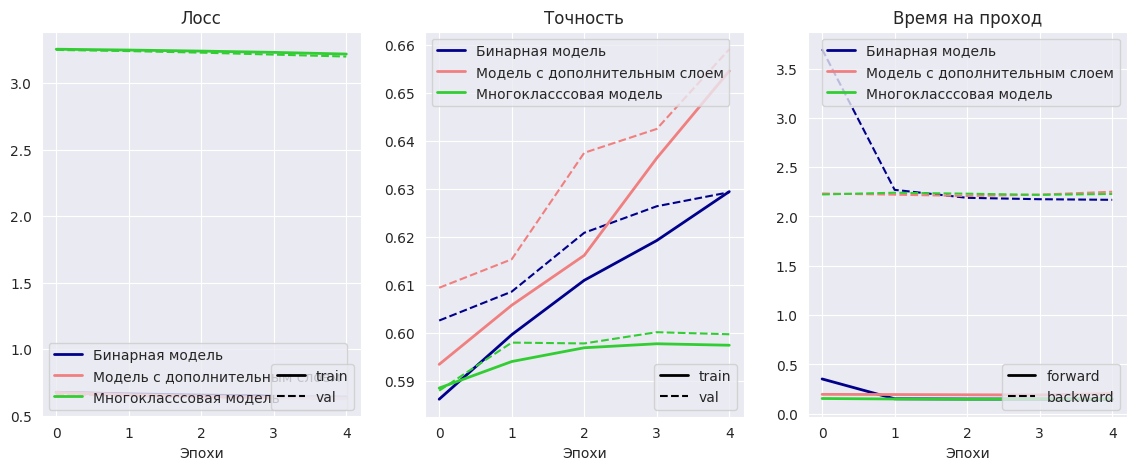

In [98]:
plot_histories([hystory, hystory_two, hystory_many], ['Бинарная модель', 'Модель с дополнительным слоем', 'Многокласссовая модель'])

In [ ]:
# Параметры нормализации CLIP (из CLIPProcessor)
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]

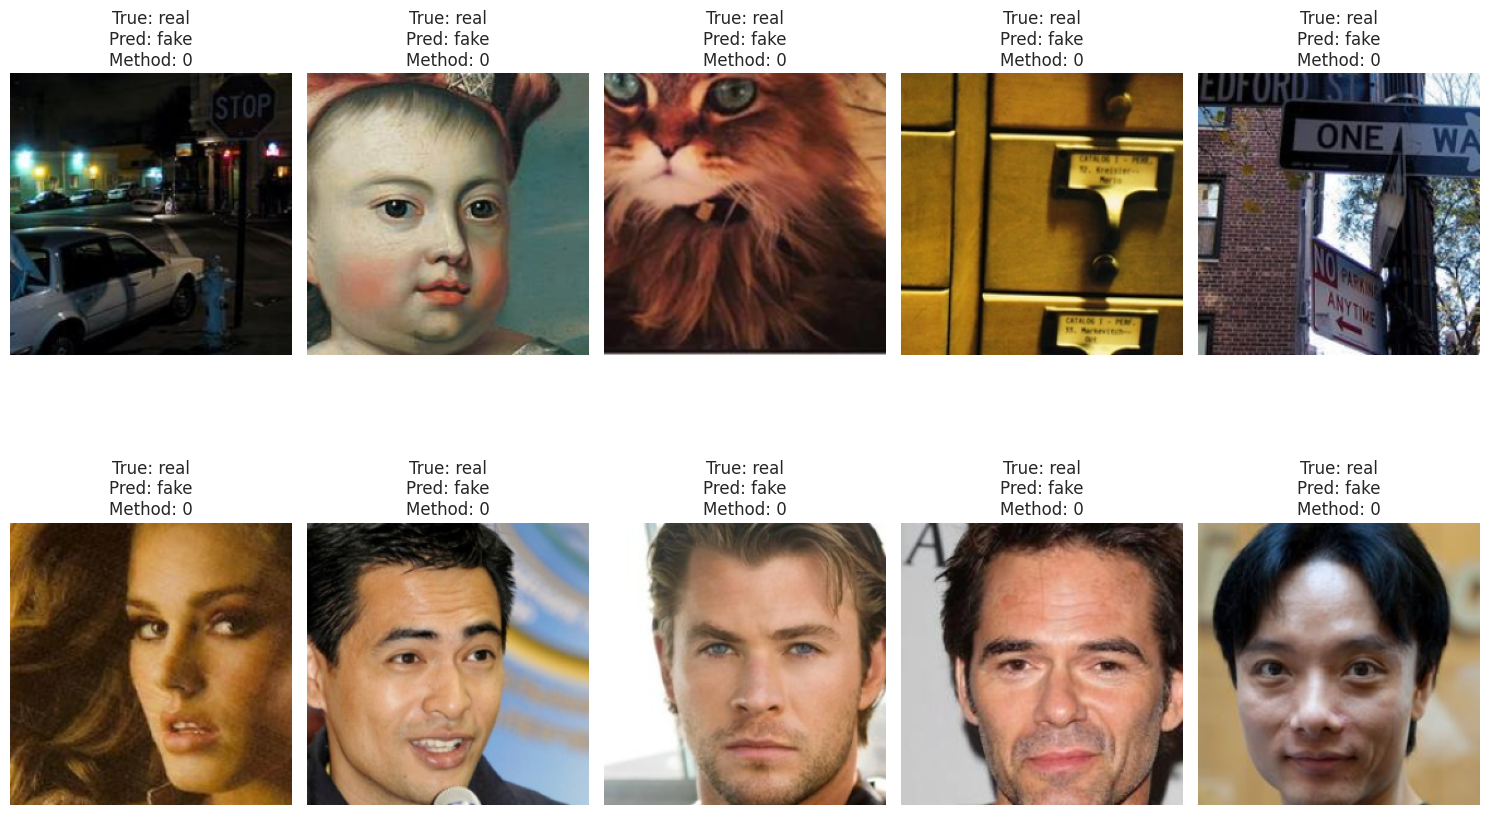

                         accuracy  precision    recall        f1   count
real                     0.211099   1.000000  0.211099  0.348607   919.0
stylegan1                0.811321   1.000000  0.811321  0.895833    53.0
stylegan2                0.950355   1.000000  0.950355  0.974545   141.0
stylegan3                0.851852   1.000000  0.851852  0.920000    54.0
big_gan                  1.000000   1.000000  1.000000  1.000000    53.0
pro_gan                  0.941176   1.000000  0.941176  0.969697    51.0
projected_gan            0.981132   1.000000  0.981132  0.990476    53.0
gau_gan                  1.000000   1.000000  1.000000  1.000000    53.0
star_gan                 0.981132   1.000000  0.981132  0.990476    53.0
gansformer               0.962264   1.000000  0.962264  0.980769    53.0
generative_inpainting    0.943396   1.000000  0.943396  0.970874    53.0
mat                      0.814815   1.000000  0.814815  0.897959    54.0
palette                  0.735849   1.000000  0.735

In [100]:
def evaluate_model(model, dataloader, device, class_names, threshold=0.5):
    model.eval()
    all_preds = []
    all_true = []
    all_methods = []
    all_probs = []
    error_samples = []

    with torch.no_grad():
        for images, methods, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            probs = torch.softmax(logits, dim=1)[:, 1]  # Преобразуем в вероятности
            preds = (probs > threshold).long().squeeze()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            all_methods.extend(ALL_METHODS[methods.numpy()])

            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    error_samples.append((
                        images[i].cpu(),
                        methods[i],
                        preds[i].item(),
                        labels[i].item()
                    ))

    all_true = np.array(all_true)
    all_preds = np.array(all_preds)
    all_methods = np.array(all_methods)
    all_probs = np.array(all_probs)

    overall_metrics = [
        accuracy_score(all_true, all_preds),
        precision_score(all_true, all_preds, average='macro'),
        recall_score(all_true, all_preds, average='macro'),
        f1_score(all_true, all_preds, average='macro'),
        len(all_true)
    ]

    # Метрики по классам
    class_metrics = {}
    for class_name in class_names:
        class_idx = class_names.index(class_name)
        mask = (all_methods == class_name)
        if sum(mask) > 0:  # Если класс присутствует в тестовых данных
            if class_name == 'real':
                class_metrics[class_name] = {
                    'accuracy': accuracy_score(all_true[mask], all_preds[mask]),
                    'precision': precision_score(all_true[mask], all_preds[mask], average='binary', pos_label=0),
                    'recall': recall_score(all_true[mask], all_preds[mask], average='binary', pos_label=0),
                    'f1': f1_score(all_true[mask], all_preds[mask], average='binary', pos_label=0),
                    'count': sum(mask)
                }
            else:
                class_metrics[class_name] = {
                    'accuracy': accuracy_score(all_true[mask], all_preds[mask]),
                    'precision': precision_score(all_true[mask], all_preds[mask], average='binary'),
                    'recall': recall_score(all_true[mask], all_preds[mask], average='binary'),
                    'f1': f1_score(all_true[mask], all_preds[mask], average='binary'),
                    'count': sum(mask)
                }

    # Визуализация ошибок
    plot_errors(error_samples)
    df = pd.DataFrame(class_metrics).T
    df.loc['overall'] = overall_metrics
    return all_probs, all_true, df

def plot_errors(error_samples, num_samples=10):
    class_names = ['real', 'fake']
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(error_samples))):
        img, method, pred, true = error_samples[i]
        img = img.permute(1, 2, 0).numpy()
        if img.shape[2] == 3:  # RGB
            img = img  # Денормализация
        else:  # Grayscale
            img = img.squeeze()

        plt.subplot(2, 5, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}\nMethod: {method}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


class_names = ['real'] + fake_methods  # ['real', 'stylegan3', 'ddpm', ...]
model = CLIPBinaryClassifier(clip_model).to(device)
model.load_state_dict(torch.load('model_weights.pth'))
predicted_probs, true_labels, class_metrics = evaluate_model(model, dataloader_test, device, class_names)
print(class_metrics)

Ну тут определенно видно жесткий дисбаланс и что-то с этим надо делать: Видно, что на реальных данных все очень плохо, короче, подберем трэшхолд.

[0.59816353 0.59798775 0.59824945 ... 0.5        0.         1.        ]
[1.00000000e+00 9.99269006e-01 9.99269006e-01 ... 7.30994152e-04
 0.00000000e+00 0.00000000e+00]


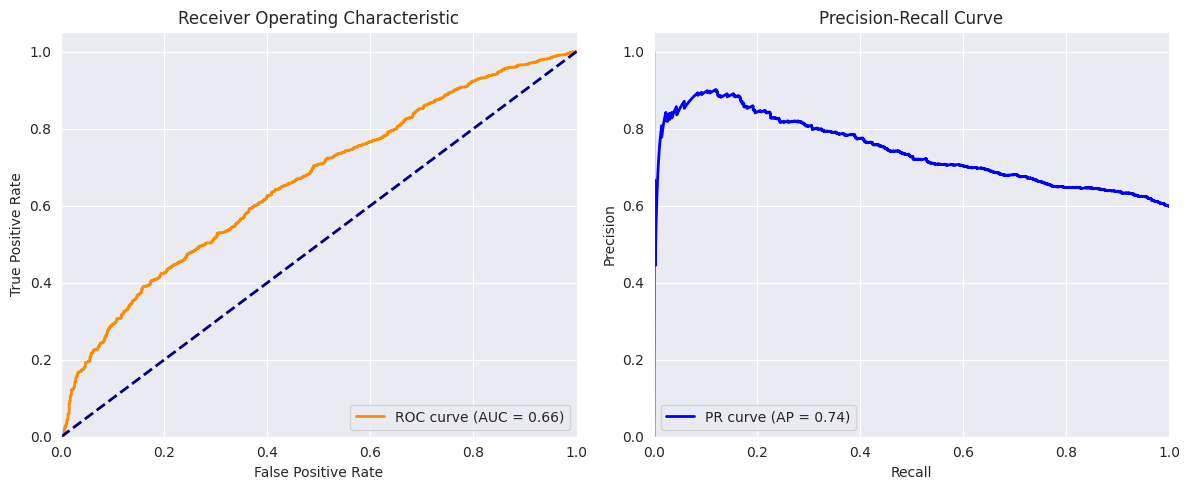

In [101]:
def plot_curves(all_probs, all_labels):
    model.eval()
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(all_labels, all_probs, pos_label=True)
    print(precision)
    print(recall)
    avg_precision = average_precision_score(all_labels, all_probs)

    plt.figure(figsize=(12, 5))

    # ROC-AUC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

plot_curves(predicted_probs, true_labels)

<ipython-input-102-0ca53fc42f31>:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*(precision*recall)/(precision+recall)


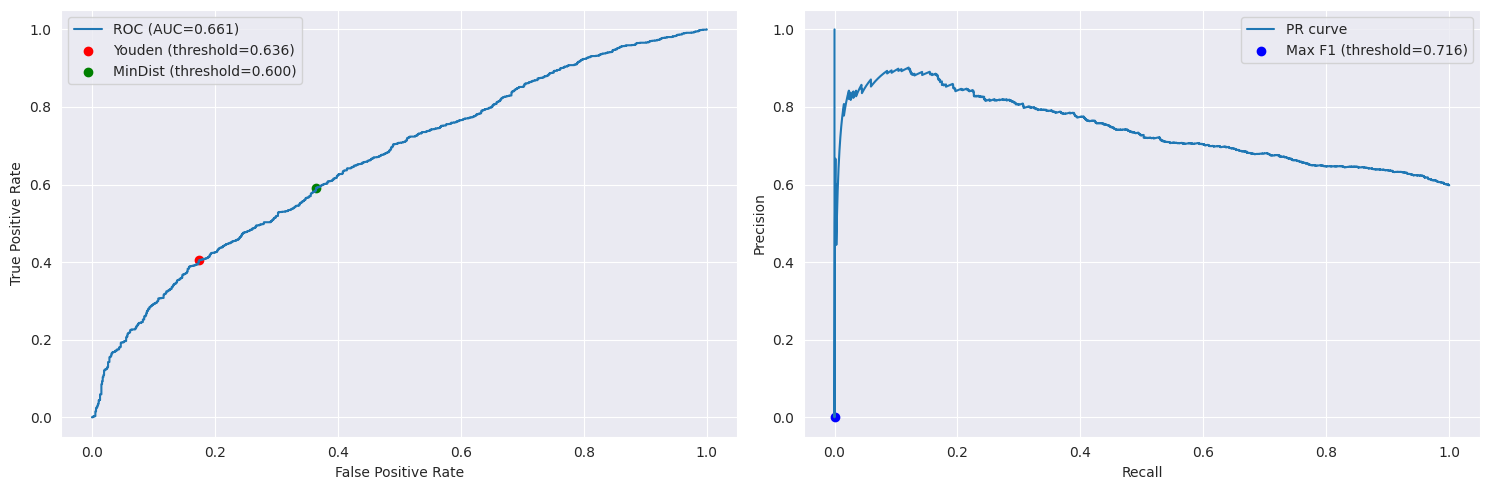

Оптимальные пороги: {'youden': np.float32(0.636293), 'f1_max': np.float32(0.7164416), 'roc_dist': np.float32(0.5997089)}


In [102]:
def find_optimal_threshold(true_labels, predicted_probs):
    fpr, tpr, roc_thresholds = roc_curve(true_labels, predicted_probs)
    youden_idx = np.argmax(tpr - fpr)
    precision, recall, pr_thresholds = precision_recall_curve(true_labels, predicted_probs)
    f1_scores = 2*(precision*recall)/(precision+recall)
    f1_idx = np.argmax(f1_scores)

    distances = np.sqrt(fpr**2 + (1-tpr)**2)
    dist_idx = np.argmin(distances)

    thresholds = {
        'youden': roc_thresholds[youden_idx],
        'f1_max': pr_thresholds[f1_idx],
        'roc_dist': roc_thresholds[dist_idx]
    }

    plt.figure(figsize=(15, 5))

    # ROC кривая
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC (AUC={auc(fpr, tpr):.3f})')
    plt.scatter(fpr[youden_idx], tpr[youden_idx], c='red',
                label=f'Youden (threshold={thresholds["youden"]:.3f})')
    plt.scatter(fpr[dist_idx], tpr[dist_idx], c='green',
                label=f'MinDist (threshold={thresholds["roc_dist"]:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Precision-Recall кривая
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='PR curve')
    plt.scatter(recall[f1_idx], precision[f1_idx], c='blue',
                label=f'Max F1 (threshold={thresholds["f1_max"]:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return thresholds

optimal_thresholds = find_optimal_threshold(true_labels, predicted_probs)
print("Оптимальные пороги:", optimal_thresholds)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

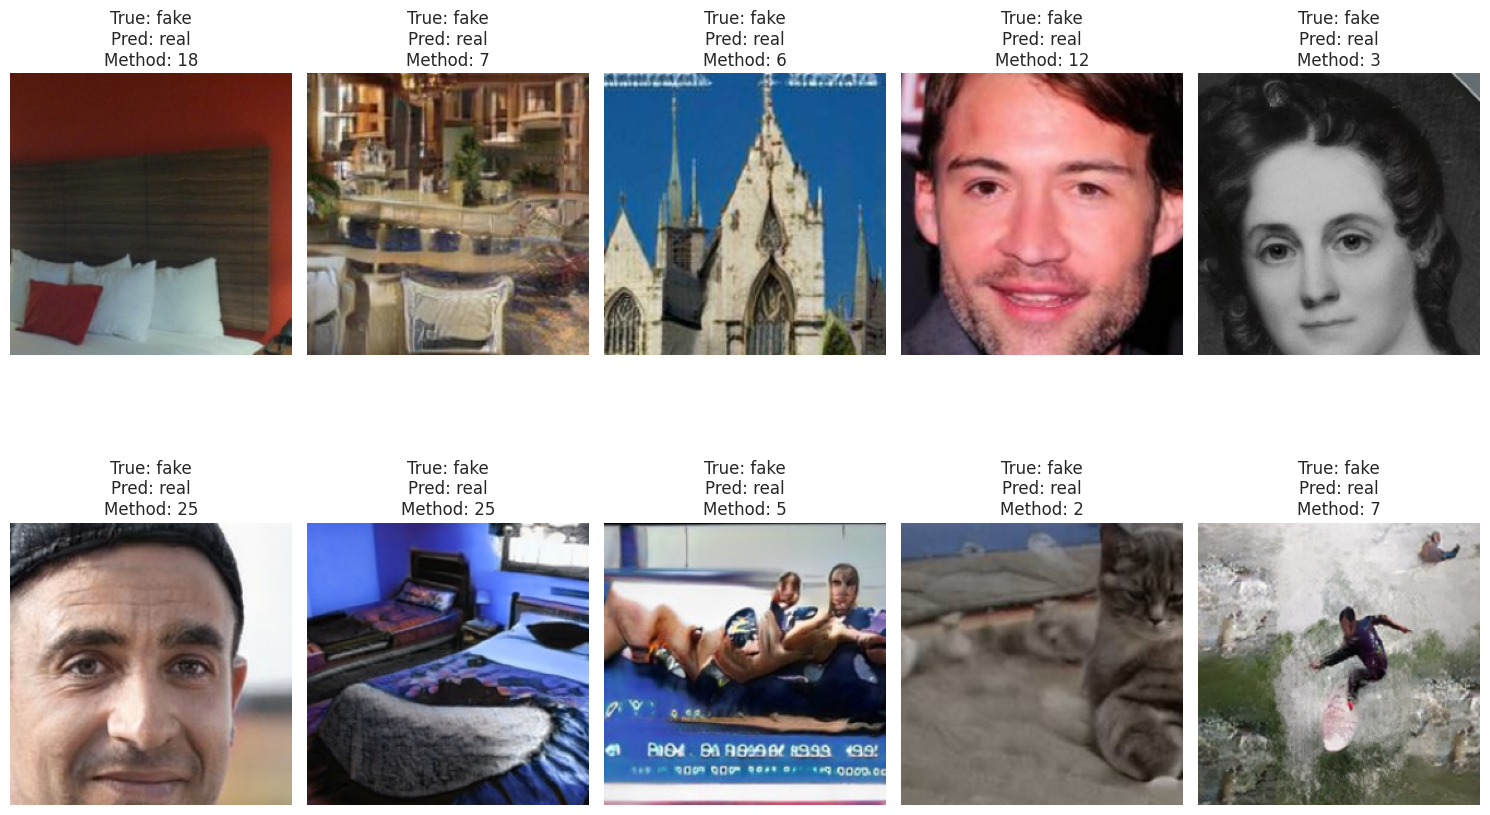

                         accuracy  precision    recall        f1   count
real                     0.992383   1.000000  0.992383  0.996177   919.0
stylegan1                0.000000   0.000000  0.000000  0.000000    53.0
stylegan2                0.007092   1.000000  0.007092  0.014085   141.0
stylegan3                0.018519   1.000000  0.018519  0.036364    54.0
big_gan                  0.207547   1.000000  0.207547  0.343750    53.0
pro_gan                  0.000000   0.000000  0.000000  0.000000    51.0
projected_gan            0.018868   1.000000  0.018868  0.037037    53.0
gau_gan                  0.037736   1.000000  0.037736  0.072727    53.0
star_gan                 0.018868   1.000000  0.018868  0.037037    53.0
gansformer               0.000000   0.000000  0.000000  0.000000    53.0
generative_inpainting    0.000000   0.000000  0.000000  0.000000    53.0
mat                      0.018519   1.000000  0.018519  0.036364    54.0
palette                  0.000000   0.000000  0.000

In [103]:
predicted_probs, true_labels, class_metrics = evaluate_model(model, dataloader_test, device, class_names, 0.7)
print(class_metrics)

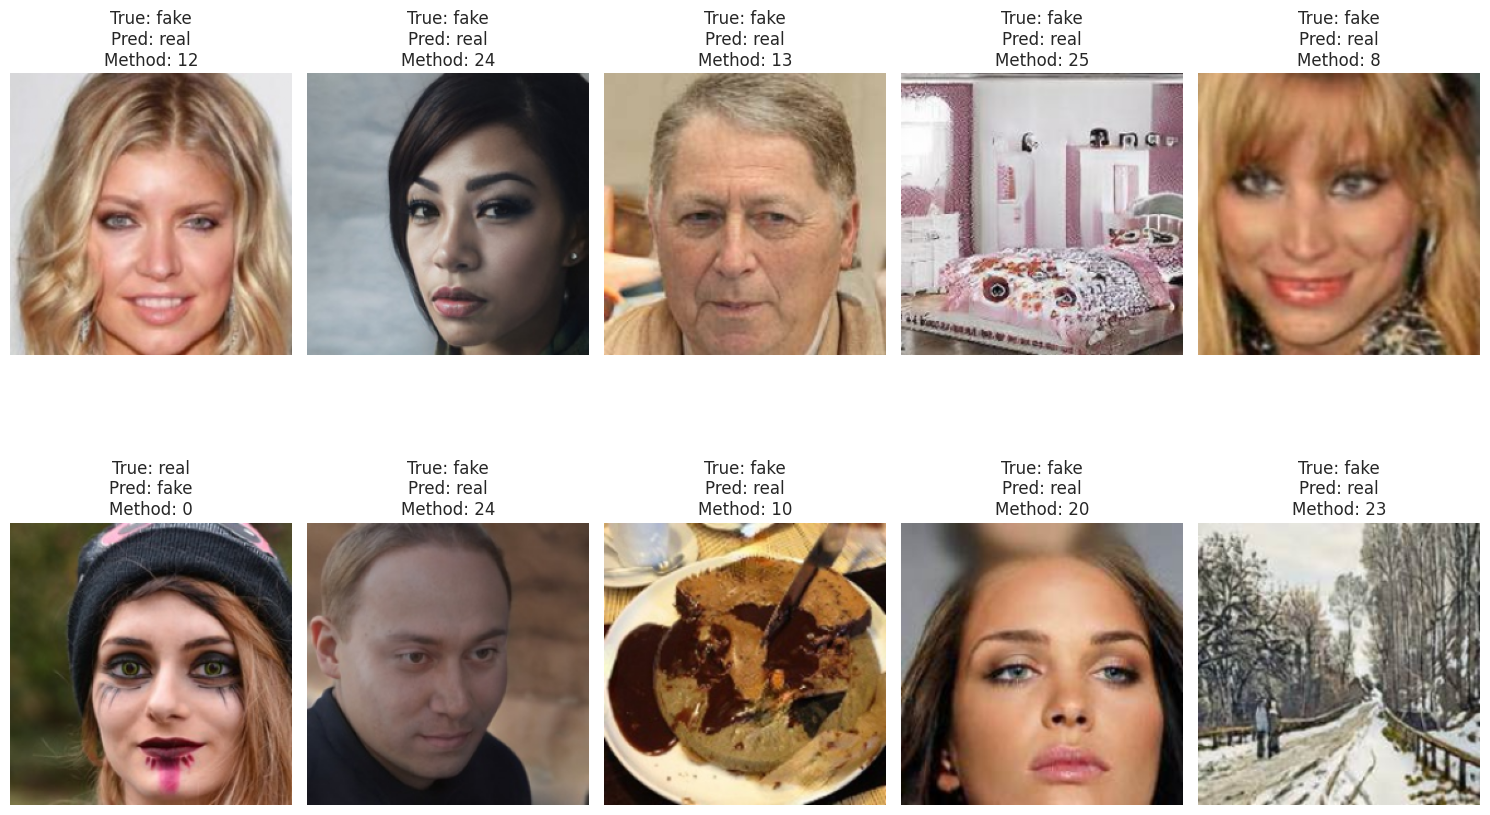

                         accuracy  precision    recall        f1   count
real                     0.825898   1.000000  0.825898  0.904648   919.0
stylegan1                0.018868   1.000000  0.018868  0.037037    53.0
stylegan2                0.304965   1.000000  0.304965  0.467391   141.0
stylegan3                0.222222   1.000000  0.222222  0.363636    54.0
big_gan                  0.849057   1.000000  0.849057  0.918367    53.0
pro_gan                  0.352941   1.000000  0.352941  0.521739    51.0
projected_gan            0.603774   1.000000  0.603774  0.752941    53.0
gau_gan                  0.716981   1.000000  0.716981  0.835165    53.0
star_gan                 0.358491   1.000000  0.358491  0.527778    53.0
gansformer               0.396226   1.000000  0.396226  0.567568    53.0
generative_inpainting    0.339623   1.000000  0.339623  0.507042    53.0
mat                      0.314815   1.000000  0.314815  0.478873    54.0
palette                  0.113208   1.000000  0.113

In [104]:
_, _, class_metrics = evaluate_model(model, dataloader_test, device, class_names, optimal_thresholds['youden'])
print(class_metrics)

Теперь перейдем к многоклассовой классификации, идея в том, что в будущем хотим научимся предсказывать с помощью двух классификаций, а сейчас просто сделаем многоклассовую и посмотрим что происходит, проведем простой анализ

Сверху это уже было реализовано, примечательно, что мы получаем там все время негативный класс и точность не особо низкая (кажется, что где-то все-таки ошибка, пока не нашел, но если это не ошибка то что-то кажется наклевывается).

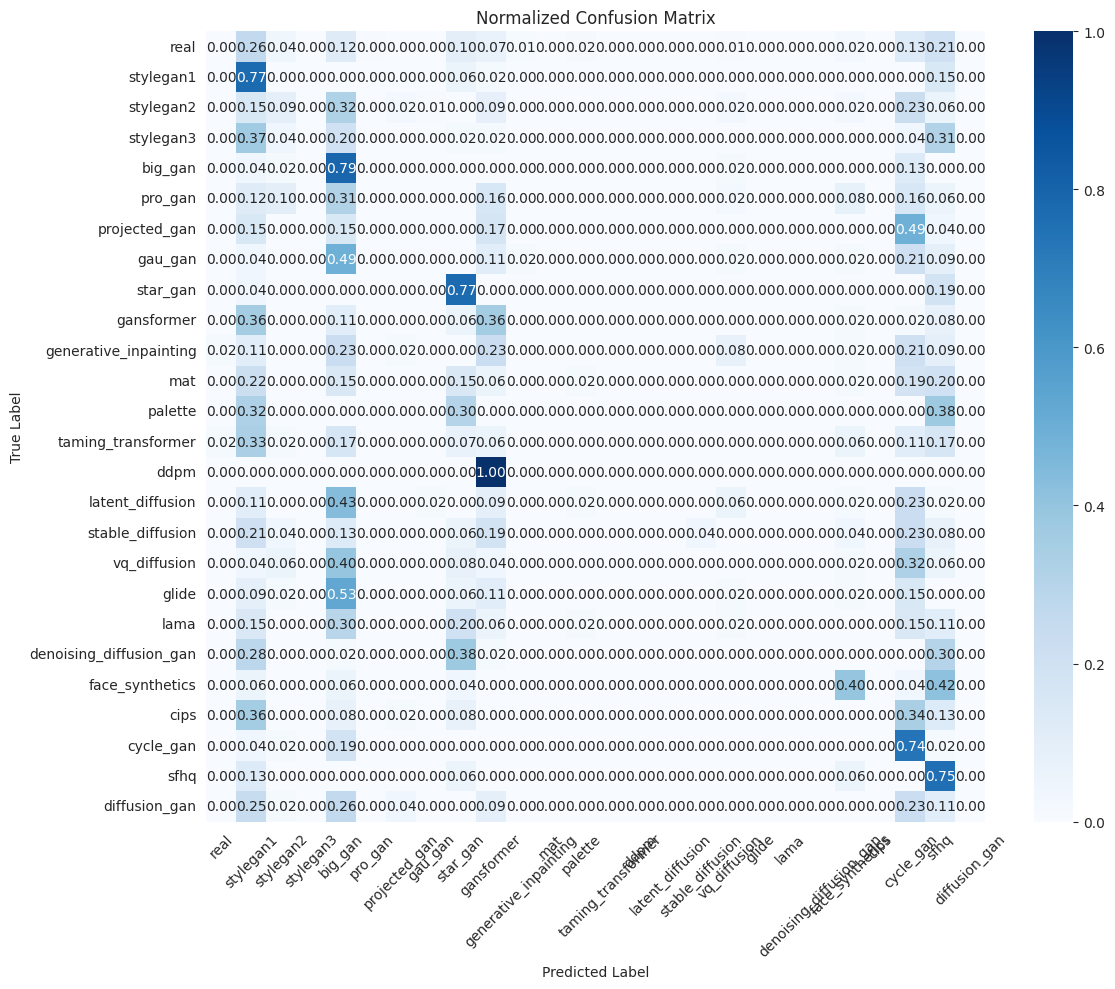

In [108]:
def plot_confusion_matrix(model, dataloader, class_names, device='cuda'):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets, _ in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm_normalized

cm = plot_confusion_matrix(model_many, dataloader_test, class_names, device='cuda')